# Setup

In [178]:
DATA_FILE_NAME = "consultation-documents-preprocessed-2025-01-06.parquet"

LANGUAGES = {
    "de",
    # "fr",
    # "it",
}

# EMBEDDING_MODEL = "openai/text-embedding-ada-002"
EMBEDDING_MODEL = "openai/text-embedding-3-large"

# FROM_YEAR = 2010
FROM_YEAR = 2000

MERGE_CLASSES = {
    # (classes, to, drop): replacement_class
    # ("RESPONSE_FORM", "SURVEY", "SYNOPTIC_TABLE", "VARIOUS_TEXT"): "VARIOUS_TEXT",
}

INCLUDE_RULE_LABELS_IN_TRAINING = {
    # "REPORT",
    "SYNOPTIC_TABLE",
    "LETTER",
}

CV_FOLDS = 5
TEST_SIZE = 0.1
RANDOM_STATE = 2718
USE_TEST_SET = True

%env MLFLOW_TRACKING_URI=sqlite:///mlruns.db

env: MLFLOW_TRACKING_URI=sqlite:///mlruns.db


In [242]:
%load_ext autoreload
%autoreload 2

import logging
import pathlib
import sys
from typing import Any

import dotenv
import mlflow
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from tqdm import tqdm

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
from research.document_types import document_title_rule_model
from research.lib import data_access, embeddings, plotting

In [181]:
dotenv.load_dotenv()

True

In [182]:
mlflow.set_experiment(f"V1. {'&'.join(sorted(LANGUAGES))}. document types")

if run := mlflow.active_run():
    logging.warning("Run = %s is already active, closing it.", run.info.run_name)
    mlflow.end_run()
run = mlflow.start_run()
print("Starting run:", run.info.run_name)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("embedding_model", EMBEDDING_MODEL)
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
;

Starting run: sneaky-kite-583


''

In [183]:
mlflow.sklearn.autolog()
tqdm.pandas()

2025/01/29 15:37:27 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.2, but the installed version is 1.6.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


# Input data preparation

In [184]:
def merge_classes(series: pd.Series) -> pd.Series:
    """Apply the MERGE_CLASSES setting to a series of document type labels."""
    series = series.copy()
    for old_classes, new_class in MERGE_CLASSES.items():
        mask = series.isin(old_classes)
        series.loc[mask] = new_class
    return series

In [185]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

## Load the external test set (manually labelled)

In [186]:
df_test_external = pd.read_excel(REPOSITORY_ROOT / "research" / "document_types" / "ground_truth.xlsx")[
    ["document_id", "ground_truth"]
].set_index("document_id")
df_test_external["ground_truth"] = merge_classes(df_test_external["ground_truth"])
df_test_external = df_test_external.dropna()
df_test_external

,ground_truth
document_id,
43657,FINAL_REPORT
40411,REPORT
43681,DRAFT
46685,RECIPIENT_LIST
40706,RECIPIENT_LIST
...,...
45231,LETTER
45040,DRAFT
40646,LETTER


## Load Fedlex data (all of it is used for training)

In [187]:
df_fedlex = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE,
    only_document_sources={"fedlex"},
    only_languages=LANGUAGES,
    starting_year=FROM_YEAR,
    mlflow=mlflow,
)
df_fedlex

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '/Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-01-06.parquet'. Exception: 
  return _dataset_source_registry.resolve(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input da

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,document_type,document_language,document_title,organisation_id,organisation_name,political_body,consultation_reviewed_at,document_source,consultation_topics_label_source,document_content_plain
0,1,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",DRAFT,de,Vernehmlassungsvorlage,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...
3,4,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",RECIPIENT_LIST,de,Adressatenliste,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...
6,7,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",LETTER,de,Begleitschreiben 2,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...
9,10,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",REPORT,de,Erläuternder Bericht,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,1. Oktober 2021 \n \n \n \n \nVerordnung des B...
12,13,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",LETTER,de,Begleitschreiben 1,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52027,53636,4940,2024-12-20,2025-04-03,Indirekter Gegenvorschlag (Änderung des Kernen...,Das Verbot des Erteilens der Rahmenbewilligung...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/2b64exk2,"[energy, spatial_planning]",LETTER,de,Begleitschreiben,44,Bundesamt für Energie,ch,2024-11-05 11:39:50,fedlex,manual,Schweizerische Eidgenossenschaft\nConfëdëratio...
52030,53639,4940,2024-12-20,2025-04-03,Indirekter Gegenvorschlag (Änderung des Kernen...,Das Verbot des Erteilens der Rahmenbewilligung...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/2b64exk2,"[energy, spatial_planning]",LETTER,de,Begleitschreiben-2,44,Bundesamt für Energie,ch,2024-11-05 11:39:50,fedlex,manual,Schweizerische Eidgenossenschaft\nConfëdëratio...
52033,53642,4940,2024-12-20,2025-04-03,Indirekter Gegenvorschlag (Änderung des Kernen...,Das Verbot des Erteilens der Rahmenbewilligung...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/2b64exk2,"[energy, spatial_planning]",REPORT,de,Erläuternder Bericht,44,Bundesamt für Energie,ch,2024-11-05 11:39:50,fedlex,manual,BFE-D-BDD93401/157\n \nEidgenössisches Departe...
52036,53645,4940,2024-12-20,2025-04-03,Indirekter Gegenvorschlag (Änderung des Kernen...,Das Verbot des Erteilens der Rahmenbewilligung...,https://fedlex.data.admin.ch/filestore/fedlex....,https:/

## Load OpenParlData and generate labels by the rule model

In [188]:
df_opd = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE,
    only_document_sources={"openparldata"},
    only_languages=LANGUAGES,
    starting_year=FROM_YEAR,
    mlflow=mlflow,
)
df_opd

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '/Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-01-06.parquet'. Exception: 
  return _dataset_source_registry.resolve(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input da

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,document_type,document_language,document_title,organisation_id,organisation_name,political_body,consultation_reviewed_at,document_source,consultation_topics_label_source,document_content_plain
38324,38325,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[economics, energy]",NaN,de,Beilage 1 zum Anhörungsbericht (Statuten) (PDF...,141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,Beilage 1 \nVerabschiedet durch Politisches Gr...
38325,38326,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[economics, energy]",NaN,de,Beilage 2 zum Anhörungsbericht (Aktionärbindun...,141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,"Stand: 20. November 2018, mit formalen Ergänzu..."
38326,38327,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[economics, energy]",NaN,de,Beilage 3 zum Anhörungsbericht (Eignerstrategi...,141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,Seite 1 von 2 Stand: 20. November 2018 \n\nEig...
38327,38328,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[economics, energy]",NaN,de,Beilage 4 zum Anhörungsbericht (NOK-Gründungsv...,141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,731.120\n\nSchaffhauser Rechtsbuch 1997 1\n\nV...
38328,38329,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[economics, energy]",NaN,de,"Anhörungsbericht (PDF, 10 Seiten, 184 KB)",141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,J:\03_Geschäfte\1_Vorträge\05_AE\Auflösung NOK...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52007,53616,4991,2024-12-18,2025-02-20,Bericht «Sonderpädagogik der St.Galler Volkssc...,Die Regierung des Kantons St.Gallen hat an ihr...,https://www.sg.ch/news/sgch_allgemein/2024/12/...,https://www.demokratis.ch/vernehmlassung/4tpw3ygc,[education],VARIOUS_TEXT,de,Bericht Sonderpädagogik der St.Galler Volksschule,156,Regierung des Kantons St. Gallen,sg,NaT,openparldata,openparldata,Kanton St.Gallen \nBildungsdepartement \n \nAm...
52008,53617,4991,2024-12-18,2025-02-20,Bericht «Sonderpädagogik der St.Galler Volkssc...,Die Regierung des Kantons St.Gallen hat an ihr...,https://www.sg.ch/news/sgch_allgemein/2024/12/...,https://www.demokratis.ch/vernehmlassung/4tpw3ygc,[education],VARIOUS_TEXT,de,Anhang 1: Bericht der Paedagogischen Hochschul...,156,Regierung des Kantons St. Gallen,sg,NaT,openparldata,openparldata,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...
52039,53648,4994,2024-12-19,2025-03-19,Vernehmlassung zum Erlass eines Gesetzes über ...,Die Bündner Regierung hat im Rahmen der Teilre...,https://www.gr.ch/DE/publikationen/vernehmlass...,https://www.demokratis.ch/vernehmlassung/v3tefzb7,[education],VARIOUS_TEXT,de,Einladungsschreiben,150,Regierung des Kantons Graubünden,gr,NaT,openparldata,openparldata,"info@ekud.gr.ch \nwww.ekud.gr.ch\nErziehungs-,..."
52040,53649,4994,2024-12-19,2025-03-19,Vernehmlassung zum Erlass eines Gesetzes über ...,Die Bündner Regierung hat im Rahmen der Teilre...,https://www.gr.ch/DE/publikationen/vernehmlass...,https://www.demokratis.ch/vernehmlassung/v3tefzb7,[education],VARIOUS_TEXT,de,Erlass,150,Regierung des Kantons Graubünden,gr,NaT,openparlda

In [189]:
# Generate rule-labels (predictions)
df_opd["prediction_rule"] = document_title_rule_model.predict(df_opd)

# Split OpenParlData: only pick certain rule-labels for training.
opd_train_index = (
    # Only pick certain rule-labels for training...
    df_opd["prediction_rule"].isin(INCLUDE_RULE_LABELS_IN_TRAINING)
    # ...but make sure we don't train on documents that are in the external test set.
    & ~df_opd["document_id"].isin(df_test_external.index)
)
df_opd_train = df_opd.loc[opd_train_index].copy()
df_opd_test = df_opd.loc[~opd_train_index].copy()
del df_opd  # Prevent mistakes; we should only explicitly access the train or the test set from now on.

# Normalise the training portion: use the rule-label as the canonical target label.
del df_opd_train["document_type"]
df_opd_train = df_opd_train.rename(columns={"prediction_rule": "document_type"})

print(f"Adding {len(df_opd_train)} OpenParlData documents to the training set:")
df_opd_train["document_type"].value_counts(dropna=False)

Adding 2234 OpenParlData documents to the training set:


document_type
LETTER            1537
SYNOPTIC_TABLE     697
Name: count, dtype: int64

## Create the input dataframe from Fedlex and a part of OpenParlData

In [190]:
df_input = pd.concat([df_fedlex, df_opd_train], ignore_index=True)

In [191]:
df_input["document_type"].value_counts(dropna=False)

document_type
LETTER            4621
DRAFT             2898
REPORT            2153
RECIPIENT_LIST    1770
FINAL_REPORT      1747
OPINION            985
SYNOPTIC_TABLE     778
VARIOUS_TEXT       418
SURVEY              13
RESPONSE_FORM        7
Name: count, dtype: int64

## Merge classes

In [192]:
df_input["document_type"] = merge_classes(df_input["document_type"])
df_input["document_type"].value_counts(dropna=False)

document_type
LETTER            4621
DRAFT             2898
REPORT            2153
RECIPIENT_LIST    1770
FINAL_REPORT      1747
OPINION            985
SYNOPTIC_TABLE     778
VARIOUS_TEXT       418
SURVEY              13
RESPONSE_FORM        7
Name: count, dtype: int64

## Define the target

In [193]:
y_encoder = OrdinalEncoder(dtype=int)
df_input["document_type_code"] = y_encoder.fit_transform(df_input[["document_type"]])

## Drop empty documents

In [194]:
empty_index = df_input["document_content_plain"].str.strip() == ""
empty_count = len(df_input[empty_index])
print(f"Empty texts: {empty_count} ({100 * empty_count / len(df_input):.1f}%)")
df_input = df_input.loc[~empty_index]

Empty texts: 994 (6.5%)


## Additional features

### contains_synopse_keyword: bool

In [258]:
def add_features(df: pd.DataFrame) -> None:
    df["contains_synopse_keyword"] = (
        df["document_content_plain"].str.slice(0, 1000).str.contains("synopse", case=False, regex=False)
    )

In [259]:
add_features(df_input)
add_features(df_opd_test)

In [260]:
df_input.groupby("document_type")["contains_synopse_keyword"].value_counts(normalize=True) * 100

document_type   contains_synopse_keyword
DRAFT           False                        99.965302
                True                          0.034698
FINAL_REPORT    False                       100.000000
LETTER          False                        99.514301
                True                          0.485699
OPINION         False                       100.000000
RECIPIENT_LIST  False                       100.000000
REPORT          False                        99.953293
                True                          0.046707
RESPONSE_FORM   False                       100.000000
SURVEY          False                        92.307692
                True                          7.692308
SYNOPTIC_TABLE  True                         73.834197
                False                        26.165803
VARIOUS_TEXT    False                        96.618357
                True                          3.381643
Name: proportion, dtype: float64

In [261]:
df_opd_test.groupby("document_type")["contains_synopse_keyword"].value_counts(normalize=True) * 100

/var/folders/zq/k8fwbncx1vg2swbktbl1t4z00000gp/T/ipykernel_52692/2192545349.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_opd_test.groupby("document_type")["contains_synopse_keyword"].value_counts(normalize=True) * 100


document_type   contains_synopse_keyword
DECISION        False                         0.0
                True                          0.0
DRAFT           False                        70.0
                True                         30.0
FINAL_REPORT    False                         0.0
                True                          0.0
LETTER          False                       100.0
                True                          0.0
LINK            False                         0.0
                True                          0.0
OPINION         False                         0.0
                True                          0.0
RECIPIENT_LIST  False                       100.0
                True                          0.0
REPORT          False                       100.0
                True                          0.0
RESPONSE_FORM   False                         0.0
                True                          0.0
SURVEY          False                       100.0
         

## Splits

### Set aside a test set

In [195]:
splitter = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

train_index, test_index = next(splitter.split(X=df_input, y=df_input["document_type_code"]))

In [236]:
df_input_train = df_input.iloc[train_index]
df_input_test = df_input.iloc[test_index]

print("Train:", df_input_train.shape)
print("Test:", df_input_test.shape)

Train: (12956, 21)
Test: (1440, 21)


In [197]:
mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

1440

### Prepare a cross-validation splitter

In [198]:
cv_splitter = sklearn.model_selection.StratifiedKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)

# Embeddings

## Tokenise and truncate to input window

In [199]:
embedding_model = embeddings.create_embedding_model(EMBEDDING_MODEL)
mlflow.log_param("embedding_model.max_input_tokens", embedding_model.max_input_tokens)

tokens_train = df_input_train["document_content_plain"].progress_map(embedding_model.tokenize)
tokens_test = df_input_test["document_content_plain"].progress_map(embedding_model.tokenize)

100%|██████████| 1440/1440 [00:04<00:00, 306.17it/s]


## Embed

In [200]:
with embeddings.use_cache(
    embedding_model,
    tqdm=tqdm,
    cache_directory=REPOSITORY_ROOT / "data" / "embeddings-cache",
    read_only=True,
) as get_embeddings:
    embeddings_train = get_embeddings(tokens_train.tolist())
    print(embeddings_train.shape)
    embeddings_test = get_embeddings(tokens_test.tolist())
    print(embeddings_test.shape)

Embedding (cached=12955, new=0): 100%|██████████| 12956/12956 [00:09<00:00, 1330.47it/s]


(12956, 3072)


Embedding (cached=1439, new=0): 100%|██████████| 1440/1440 [00:01<00:00, 1421.05it/s]

(1440, 3072)


# Classification

In [240]:
X_train = np.column_stack((embeddings_train, df_input_train["contains_synopse_keyword"]))
X_test = np.column_stack((embeddings_test, df_input_test["contains_synopse_keyword"]))
y_train = df_input_train["document_type_code"]
y_test = df_input_test["document_type_code"]

print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

Train (12956, 3073) (12956,)
Test (1440, 3073) (1440,)


In [243]:
classifier = make_pipeline(
    ColumnTransformer(
        [
            (
                "embeddings",
                make_pipeline(
                    StandardScaler(),
                    PCA(n_components=20, random_state=RANDOM_STATE),
                ),
                slice(0, -1),
            ),
            ("passthrough", "passthrough", [-1]),
        ]
    ),
    LogisticRegression(max_iter=1000),
)
classifier

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('embeddings',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=20,
                                                                       random_state=2718))]),
                                                  slice(0, -1, None)),
                                                 ('passthrough', 'passthrough',
                                                  [-1])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [249]:
if "pca" in classifier.named_steps:
    mlflow.log_param("pca_n_components", classifier.named_steps["pca"].get_params()["n_components"])

In [250]:
def explained_variance_scorer(pipeline: Pipeline, X: Any, y: Any = None) -> np.float64:
    try:
        pca = pipeline.named_steps["pca"]
    except KeyError:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_weighted",
    "recall": "recall_weighted",
    "f1": "f1_weighted",
    "pca_explained_variance": explained_variance_scorer,
}

scores_docs = sklearn.model_selection.cross_validate(
    classifier,
    X=X_train,
    y=y_train,
    cv=cv_splitter,
    scoring=scoring,
)
scores_docs

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/linear_model/

{'fit_time': array([1.60127783, 1.41218615, 1.57379985, 1.57186389, 1.56924701]),
 'score_time': array([0.04222107, 0.02589369, 0.02418208, 0.02469802, 0.02768493]),
 'test_precision': array([0.92669154, 0.92618871, 0.92387485, 0.92213006, 0.92118043]),
 'test_recall': array([0.93171296, 0.92975685, 0.93130066, 0.9293709 , 0.9301428 ]),
 'test_f1': array([0.92714996, 0.92410702, 0.92548268, 0.92389431, 0.92368707]),
 'test_pca_explained_variance': array([nan, nan, nan, nan, nan])}

## Evaluation of the cross-validation

In [251]:
avg_scores_docs = {k: np.round(np.mean(v), 4) for k, v in scores_docs.items()}
mlflow.log_metrics({k.replace("test_", "cv_"): v for k, v in avg_scores_docs.items() if k.startswith("test_")})

print("Per-document CV scores:")
print(f"Precision: {avg_scores_docs['test_precision']:.4f} (+/- {np.std(scores_docs['test_precision']):.4f})")
print(f"Recall:    {avg_scores_docs['test_recall']:.4f} (+/- {np.std(scores_docs['test_recall']):.4f})")
print(f"F1:        {avg_scores_docs['test_f1']:.4f} (+/- {np.std(scores_docs['test_f1']):.4f})")

Per-document CV scores:
Precision: 0.9240 (+/- 0.0022)
Recall:    0.9305 (+/- 0.0009)
F1:        0.9249 (+/- 0.0013)


### Use subsets of the training set to re-train and evaluate. This gives us a single model to run reports on. 

In [252]:
cv_test_splitter = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

cv_train_index, cv_test_index = next(cv_test_splitter.split(X=X_train, y=y_train))

X_cv_train = X_train[cv_train_index]
y_cv_train = y_train.iloc[cv_train_index]
X_cv_test = X_train[cv_test_index]
y_cv_test = y_train.iloc[cv_test_index]

In [253]:
classifier.fit(X_cv_train, y_cv_train)
cv_test_predictions = classifier.predict(X_cv_test)

2025/01/29 16:30:03 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/01/29 16:30:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


                precision    recall  f1-score   support

         DRAFT       0.89      0.93      0.91       259
  FINAL_REPORT       0.96      0.97      0.97       157
        LETTER       0.98      0.99      0.98       334
       OPINION       0.94      0.89      0.91        87
RECIPIENT_LIST       1.00      1.00      1.00       158
        REPORT       0.88      0.92      0.90       193
 RESPONSE_FORM       1.00      1.00      1.00         1
        SURVEY       0.33      1.00      0.50         1
SYNOPTIC_TABLE       0.91      0.90      0.91        69
  VARIOUS_TEXT       0.47      0.19      0.27        37

      accuracy                           0.93      1296
     macro avg       0.84      0.88      0.83      1296
  weighted avg       0.92      0.93      0.93      1296



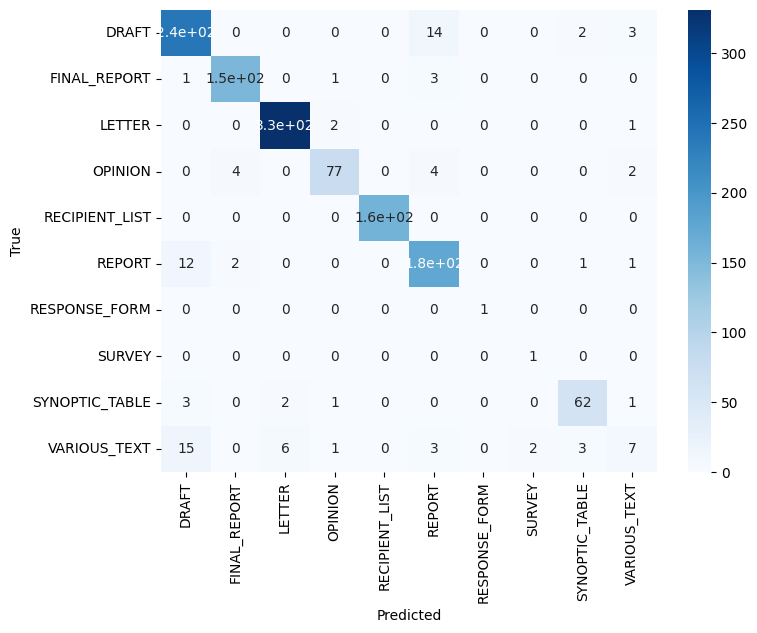

In [254]:
target_names = y_encoder.categories_[0]
print(
    sklearn.metrics.classification_report(
        y_cv_test,
        cv_test_predictions,
        target_names=target_names,
        labels=range(len(target_names)),
    )
)

display(plotting.plot_confusion_matrix_heatmap(y_cv_test, cv_test_predictions, target_names=target_names))

***

## Evaluation on the test set (USE SPARINGLY)

In [255]:
if USE_TEST_SET:
    classifier.fit(X_train, y_train)
    test_ground_truth_docs = y_test
    test_predictions_docs = classifier.predict(X_test)

    print("docs: ground truth", test_ground_truth_docs.shape)
    print("docs: predictions", test_predictions_docs.shape)

    print(
        sklearn.metrics.classification_report(
            test_ground_truth_docs,
            test_predictions_docs,
            target_names=y_encoder.categories_[0],
            labels=range(len(y_encoder.categories_[0])),
            zero_division=np.nan,
        )
    )

    test_precision, test_recall, test_f1, _ = sklearn.metrics.precision_recall_fscore_support(
        test_ground_truth_docs,
        test_predictions_docs,
        average="weighted",
        zero_division=np.nan,
    )
    mlflow.log_metrics({"test_precision": test_precision, "test_recall": test_recall, "test_f1": test_f1})

2025/01/29 16:30:21 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/01/29 16:30:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


docs: ground truth (1440,)
docs: predictions (1440,)
                precision    recall  f1-score   support

         DRAFT       0.91      0.95      0.93       288
  FINAL_REPORT       0.97      0.98      0.97       174
        LETTER       0.98      0.99      0.99       371
       OPINION       0.89      0.86      0.87        97
RECIPIENT_LIST       0.99      0.99      0.99       176
        REPORT       0.89      0.95      0.92       214
 RESPONSE_FORM        nan      0.00      0.00         1
        SURVEY       1.00      1.00      1.00         1
SYNOPTIC_TABLE       0.96      0.88      0.92        77
  VARIOUS_TEXT       0.67      0.29      0.41        41

      accuracy                           0.94      1440
     macro avg       0.92      0.79      0.80      1440
  weighted avg       0.94      0.94      0.94      1440



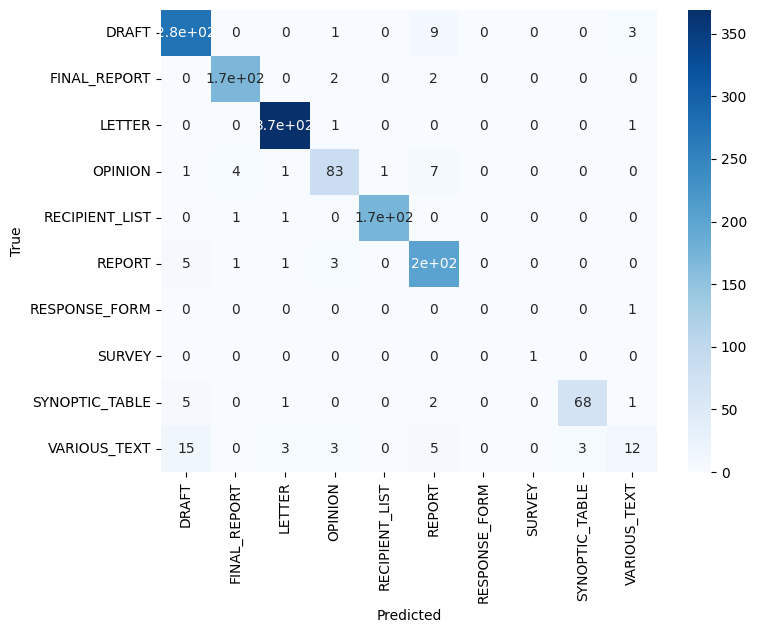

In [256]:
if USE_TEST_SET:
    display(
        plotting.plot_confusion_matrix_heatmap(
            test_ground_truth_docs, test_predictions_docs, target_names=y_encoder.categories_[0]
        )
    )

***

# Rule-based & ML model evaluation

## Embed the OpenParlData test set

In [211]:
tokens_opd_test = df_opd_test["document_content_plain"].progress_map(embedding_model.tokenize)

with embeddings.use_cache(
    embedding_model,
    tqdm=tqdm,
    cache_directory=REPOSITORY_ROOT / "data" / "embeddings-cache",
    read_only=True,
) as get_embeddings:
    embeddings_opd_test = get_embeddings(tokens_opd_test.tolist())
    print(embeddings_opd_test.shape)

Embedding (cached=7616, new=0): 100%|██████████| 7617/7617 [00:06<00:00, 1267.20it/s]


(7617, 3072)


In [212]:
df_opd_test["embedding"] = embeddings_opd_test.tolist()

## Merge classes in the test set

In [213]:
df_opd_test["document_type"] = merge_classes(df_opd_test["document_type"])

## Test both the rule-based model and the sklearn model on a sample of OpenParlData

In [264]:
# Option A: random sample
# sample_batch = df_opd_test.sample(10)

# Option B: Use the same sample batch for now: the one where we've manually added ground truth labels
sample_batch = df_opd_test[df_opd_test["document_id"].isin(df_test_external.index)].copy()
print(len(sample_batch))

127


Use both models to generate predictions:

In [265]:
X_sample_batch = np.column_stack(
    (
        np.array(sample_batch["embedding"].tolist()),
        sample_batch["contains_synopse_keyword"],
    )
)
X_sample_batch.shape

(127, 3073)

In [266]:
sample_batch["prediction_rule"] = merge_classes(document_title_rule_model.predict(sample_batch))


sample_predictions = classifier.predict(X_sample_batch)
sample_batch["prediction_ml"] = y_encoder.inverse_transform(sample_predictions.reshape(-1, 1)).reshape(1, -1)[0]

(Sample option A only) Copy the sample to the clipboard...

In [267]:
# sample_batch[["document_id", "document_source_url", "document_title"]].to_clipboard(index=False)

(Sample option A only)  ...after adding the true labels, run this to load them back in here:

In [268]:
# ground_truth = pd.read_excel(REPOSITORY_ROOT / "research" / "document_types" / "ground_truth.xlsx")[
#     ["document_id", "ground_truth"]
# ].set_index("document_id")

### Display all samples

In [269]:
sample_batch_with_ground_truth = sample_batch.join(df_test_external, on="document_id")

sample_batch_with_ground_truth[
    [
        "document_id",
        "political_body",
        "consultation_url",
        "document_source_url",
        "document_title",
        "ground_truth",
        "prediction_rule",
        "prediction_ml",
    ]
].style.format(
    {
        "consultation_url": lambda x: f'<a href="{x}">vnl</a>',
        "document_source_url": lambda x: f'<a href="{x}">doc</a>',
    }
).set_table_styles([{"selector": "th,td", "props": [("text-align", "left")]}])

,document_id,political_body,consultation_url,document_source_url,document_title,ground_truth,prediction_rule,prediction_ml
38521,38522,ag,vnl,doc,"Beilage 1 zum Anhörungsbericht (PDF, 84 Seiten, 717 KB)",SYNOPTIC_TABLE,SYNOPTIC_TABLE,SYNOPTIC_TABLE
38570,38571,ag,vnl,doc,"Planungsbericht (PDF, 31 Seiten, 2,7 MB)",VARIOUS_TEXT,REPORT,REPORT
38660,38684,ag,vnl,doc,"Information (PDF, 8 Seiten, 450 KB)",REPORT,VARIOUS_TEXT,LETTER
38664,38688,ag,vnl,doc,"Schreiben der Vorsteherin (PDF, 2 Seiten, 32 KB)",LETTER,LETTER,LETTER
38747,38771,ag,vnl,doc,"Anpassung allgemeine Nutzungsplanung (PDF, 52 Seiten, 6,1 MB)",REPORT,None,OPINION
38766,38790,ag,vnl,doc,"Beilage zum Anhörungsbericht (Synopse BauG) (PDF, 6 Seiten, 47 KB)",SYNOPTIC_TABLE,None,SYNOPTIC_TABLE
38830,38854,ag,vnl,doc,"Adressatenliste (PDF, 5 Seiten, 26 KB)",RECIPIENT_LIST,RECIPIENT_LIST,RECIPIENT_LIST
38930,38954,ag,vnl,doc,"Anhörungsbericht (PDF, 99 Seiten, 924 KB)",REPORT,REPORT,REPORT
39074,39098,ag,vnl,doc,"Beilage 3 zum Anhörungsbericht (Synopse GGV) (PDF, 2 Seiten, 81 KB)",SYNOPTIC_TABLE,SYNOPTIC_TABLE,SYNOPTIC_TABLE
39240,39264,ag,vnl,doc,"Schreiben des Vorstehers (PDF, 2 Seiten, 1,5 MB)",LETTER,LETTER,DRAFT


In [270]:
# sample_batch.loc[sample_batch["document_id"] == 48487]

In [271]:
sample_batch_with_ground_truth["ground_truth"].value_counts(dropna=False)

ground_truth
REPORT            31
DRAFT             26
LETTER            18
SYNOPTIC_TABLE    17
VARIOUS_TEXT      12
RECIPIENT_LIST     9
FINAL_REPORT       8
RESPONSE_FORM      5
SURVEY             1
Name: count, dtype: int64

### ML model vs. ground truth

In [272]:
print(
    sklearn.metrics.classification_report(
        sample_batch_with_ground_truth["ground_truth"],
        sample_batch_with_ground_truth["prediction_ml"],
        zero_division=np.nan,
    )
)

                precision    recall  f1-score   support

         DRAFT       0.45      0.19      0.27        26
  FINAL_REPORT       0.50      0.12      0.20         8
        LETTER       0.83      0.83      0.83        18
       OPINION       0.00       nan      0.00         0
RECIPIENT_LIST       0.89      0.89      0.89         9
        REPORT       0.75      0.39      0.51        31
 RESPONSE_FORM        nan      0.00      0.00         5
        SURVEY        nan      0.00      0.00         1
SYNOPTIC_TABLE       0.29      0.94      0.44        17
  VARIOUS_TEXT       1.00      0.08      0.15        12

      accuracy                           0.46       127
     macro avg       0.59      0.38      0.33       127
  weighted avg       0.65      0.46      0.45       127



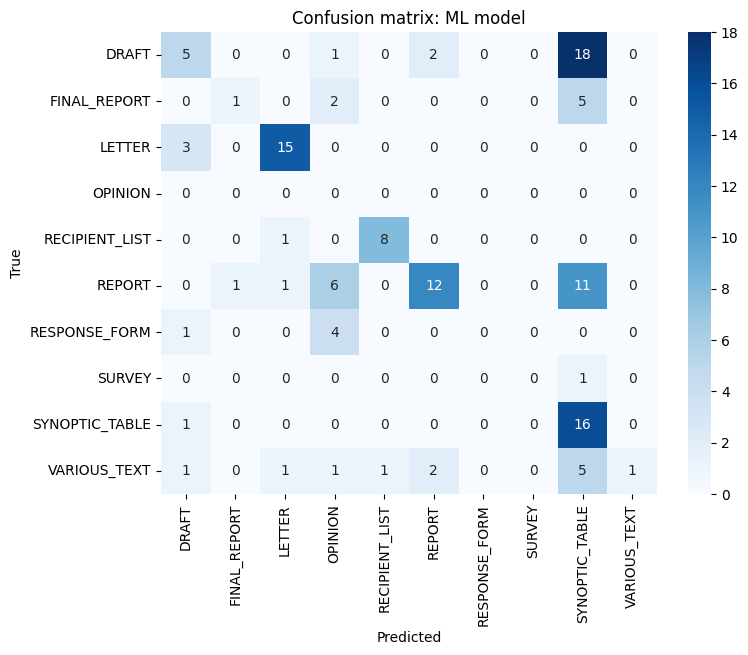

In [273]:
plotting.plot_confusion_matrix_heatmap(
    sample_batch_with_ground_truth["ground_truth"],
    sample_batch_with_ground_truth["prediction_ml"],
    target_names=target_names,
    title="ML model",
    # normalize="true",
)

### Rule-based model vs. ground truth

In [223]:
_df = sample_batch_with_ground_truth[sample_batch_with_ground_truth["prediction_rule"].notna()]
print(sklearn.metrics.classification_report(_df["ground_truth"], _df["prediction_rule"], zero_division=np.nan))

                precision    recall  f1-score   support

         DRAFT       0.77      0.77      0.77        13
  FINAL_REPORT       1.00      0.33      0.50         6
        LETTER       1.00      1.00      1.00        16
RECIPIENT_LIST       1.00      0.86      0.92         7
        REPORT       0.89      0.85      0.87        20
 RESPONSE_FORM       1.00      0.33      0.50         3
        SURVEY       0.00       nan      0.00         0
SYNOPTIC_TABLE       1.00      0.85      0.92        13
  VARIOUS_TEXT       0.25      0.75      0.38         4

      accuracy                           0.80        82
     macro avg       0.77      0.72      0.65        82
  weighted avg       0.90      0.80      0.83        82



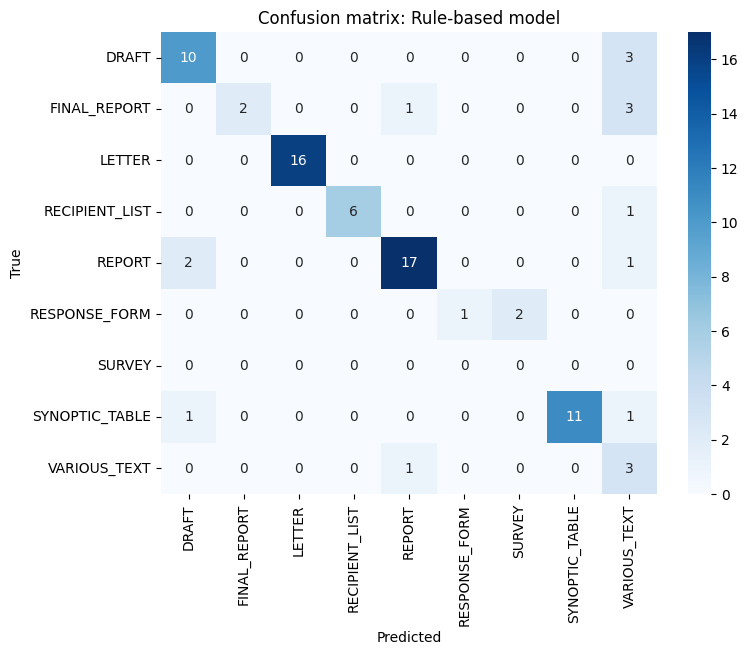

In [224]:
plotting.plot_confusion_matrix_heatmap(
    _df["ground_truth"],
    _df["prediction_rule"],
    target_names=[t for t in target_names if t not in {"OPINION"}],  # TODO: find a cleaner way to do this
    title="Rule-based model",
    # normalize="true",
)

***

# End MLflow run

In [225]:
mlflow.end_run()